In [1]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate
from collections import OrderedDict

matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
# These params are still wrong... need to figure out the correct ones
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=0,logzsol=0.0,dust_type=2,dust2=0.2)

In [3]:
age = 0.5 #Gyr
z = 3 #redshift #### For now just testing with optical filters
print(sp.libraries)

sdss_bands = fsps.find_filter('sdss')
print(sdss_bands)

print(sp.get_mags(tage=age, bands=sdss_bands))
sp.params['logzsol'] = -1

print(sp.get_mags(tage=age, bands=sdss_bands))
wave, spec = sp.get_spectrum(tage=age,peraa=True)

(b'pdva', b'miles')
['sdss_i', 'sdss_g', 'sdss_r', 'sdss_u', 'sdss_z']
[ 4.03628976  4.35212426  4.15019322  5.65132907  3.90720404]
[ 3.88921064  4.1407593   3.97991823  5.14744303  3.8268405 ]


In [4]:
# via Ned Wright's cosmology calculator: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# z=3 => 25924.2 Mpc => 25924.2e+6 pc => ~ 8e+28 cm
D = 8e+28 # cm
L_sol = 3.828e+33 # erg * s^-1
flux_factor = L_sol/(4*np.pi*D**2)
jansky = 1e-23 # erg * s^-1 * cm^-2 * Hz

# Window the spectra
indices = np.where((wave >= 500) & (wave <= 20000))

useWave, useSpec = wave[indices], spec[indices]

# Convert to Jansky
useSpec = useSpec*(flux_factor/jansky)*1e+6 # micro-Janskys
z0_wave = useWave
z3_wave = z0_wave * (z+1)

In [5]:
# Load filters
class telescope_filter:
    def __init__(self, name, wavelength, transmittance):
        self.name = name
        self.wavelength = wavelength
        self.transmittance = transmittance
        
    def __str__(self):
        return str(self.name)

colors = ["purple","blue","cyan","green", "red", "brown", "black", "red", "green", "cyan", "blue"]

# Data can be found here: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php
pivot_wavelengths = [4328.2, 5921.1, 7692.4, 9033.1, 10552.0, 12486.0, 15369, 19886.48, 27617.40, 35683.62, 44043.14]
filter_names = ["WFC_F435W", "WFC_F606W", "WFC_F775W", "WFC_F850LP", "WFC_F105W", "WFC_F125W", "WFC_F160W",
               "NIRISS_F200W", "NIRISS_F277W", "NIRISS_F356W", "NIRISS_F444W"]

telescope_filters = OrderedDict()
for i,fn in enumerate(filter_names):
    with open(("telescope_filters/%s.dat" % fn),"r") as data:
        reader = csv.reader(data, delimiter=" ")
        wv = []
        t = []
        for row in reader:
            wv.append(float(row[0])) # wavelength
            t.append(float(row[1])) # transmittance

        fn_pretty = fn.replace("_"," ")
        telescope_filters[fn_pretty] = telescope_filter(fn_pretty,wv,t)

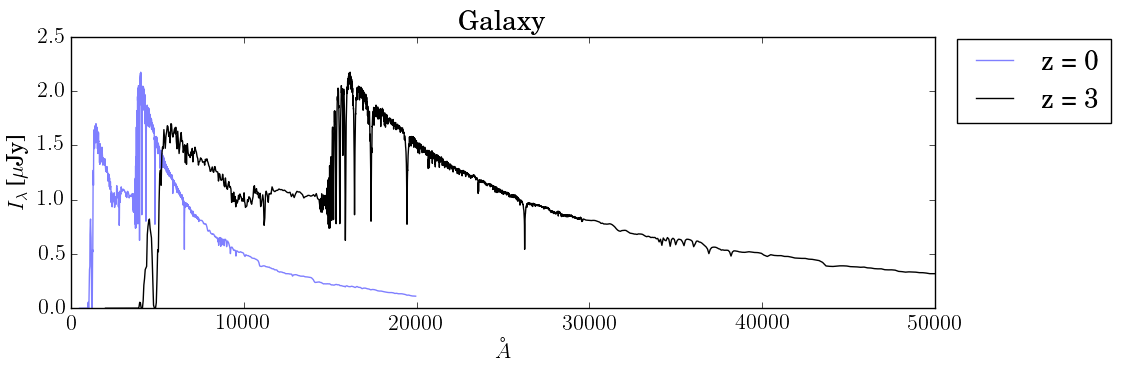

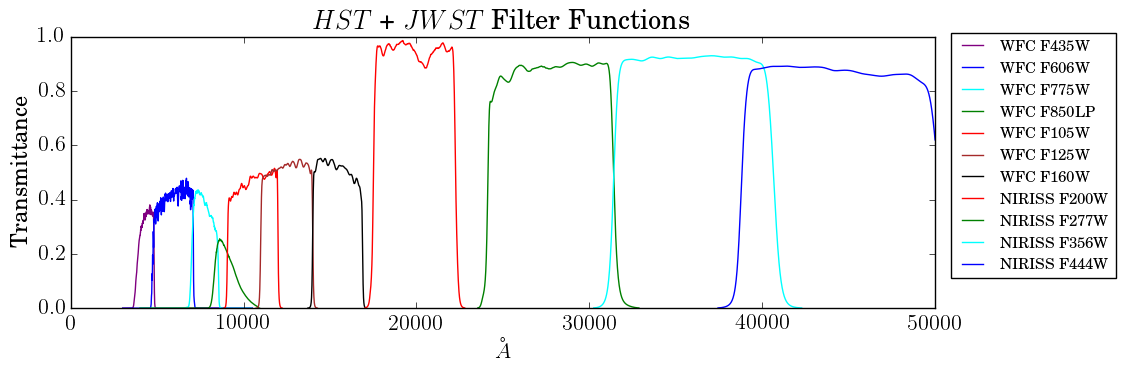

In [6]:
fig = plt.figure(figsize=(10, 4)) 
plt.plot(z0_wave,useSpec,color='b', label="z = 0",alpha=0.5)
plt.plot(z3_wave,useSpec,color='k',label="z = 3")
plt.title("Galaxy")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.xlim([0,50000])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)
plt.tight_layout()    
plt.show()



fig = plt.figure(figsize=(10, 4)) 
for i,flt_name in enumerate(telescope_filters):
    plt.plot(telescope_filters[flt_name].wavelength,
             telescope_filters[flt_name].transmittance, 
             color=colors[i], 
             label=flt_name)

plt.title("$HST$ + $JWST$ Filter Functions")
plt.xlabel(r"$\AA$")
plt.ylabel("Transmittance")
plt.xlim([0,50000])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)

plt.tight_layout()    
plt.show()

In [7]:
# Expand arrays slightly to allow for interpolation
for flt_name in telescope_filters:
    
    lambda_min = np.min(telescope_filters[flt_name].wavelength)
    lambda_max = np.max(telescope_filters[flt_name].wavelength)
    
    # Pad arrays with extreme lower and upper bound in wavelength
    telescope_filters[flt_name].wavelength = np.pad(telescope_filters[flt_name].wavelength,(10,0),'linear_ramp',end_values=(100,lambda_min))
    telescope_filters[flt_name].wavelength = np.pad(telescope_filters[flt_name].wavelength,(0,10),'linear_ramp',end_values=(lambda_max,100000))
    
    # For these padded values, set transmittance to zero.
    telescope_filters[flt_name].transmittance = np.pad(telescope_filters[flt_name].transmittance,(10,0),'constant',constant_values=(0,0))
    telescope_filters[flt_name].transmittance = np.pad(telescope_filters[flt_name].transmittance,(0,10),'constant',constant_values=(0,0))      

In [8]:
z0_bandpass_flux = {}
z3_bandpass_flux = {}
filter_funcs = {}

for flt_name in telescope_filters:
    # Interpolate filter function to the size of the spectra input array
    filter_func = interpolate.interp1d(telescope_filters[flt_name].wavelength, 
                                       telescope_filters[flt_name].transmittance)
    filter_funcs[flt_name] = filter_func
    
    # Scale real flux by filter response
    z0_bandpass_flux[flt_name] = filter_func(z0_wave)*useSpec
    z3_bandpass_flux[flt_name] = filter_func(z3_wave)*useSpec

In [9]:
def getBandpassABMag(flux_in_microjansky, transmission_func, wave):
    if (flux_in_microjansky == 0.0):
        return float('NaN')
    
    top = np.sum(flux_in_microjansky/1e+6)
    bottom = np.sum(3631.0*transmission_func(wave))
    
    return -(5./2.)*np.log10(top/bottom)

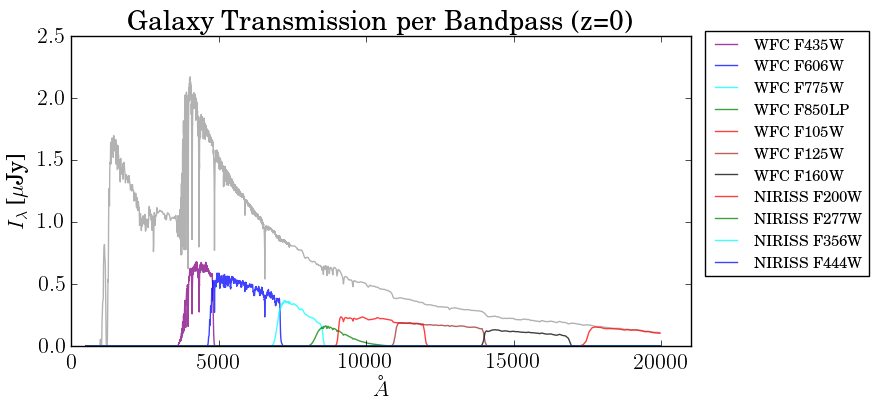

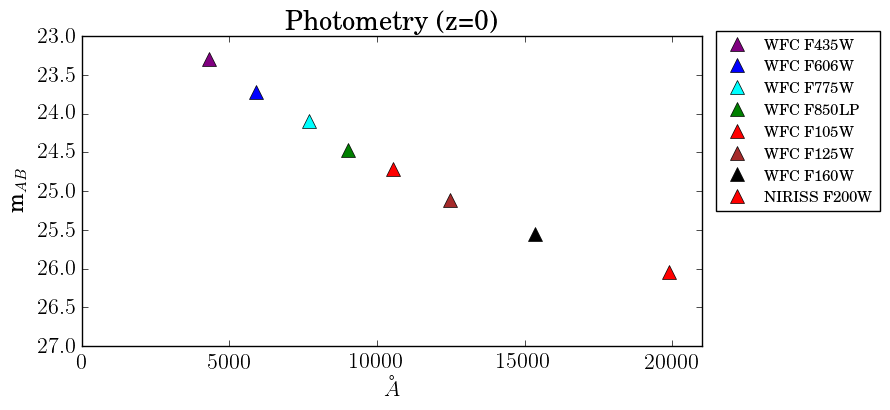

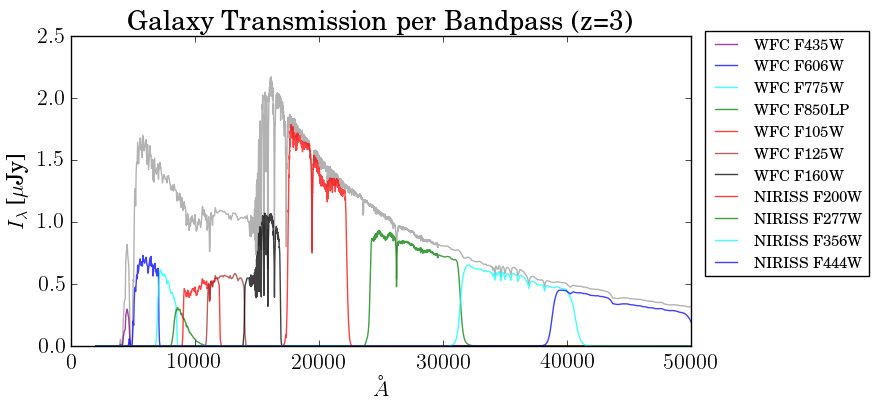

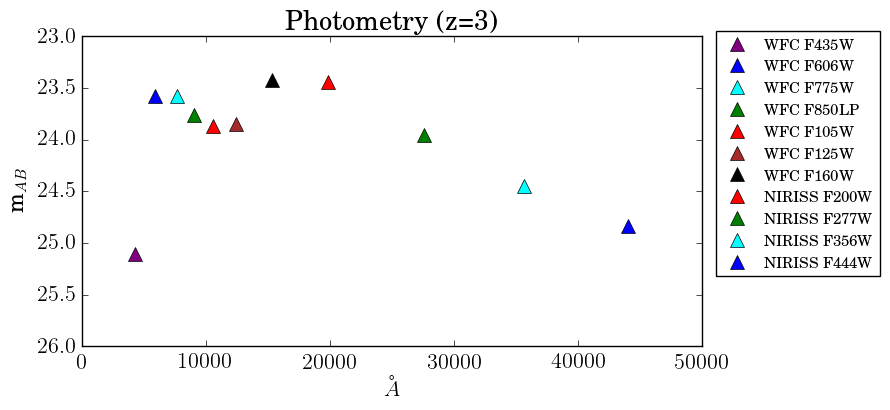

In [10]:
fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(z0_wave,useSpec,color='k',alpha=0.3)

phot_pts = []
# Overplot flux through each bandpass
for i,flt_name in enumerate(telescope_filters):
    # Don't know if this is working... but I think it might be the general idea.
    pt = np.sum(z0_bandpass_flux[flt_name])
    phot_pts.append(getBandpassABMag(pt,filter_funcs[flt_name], z0_wave))
    
    if not np.isnan(pt):
        plt.plot(z0_wave,z0_bandpass_flux[flt_name],color=colors[i],label=flt_name,alpha=0.75)    

plt.title("Galaxy Transmission per Bandpass (z=0)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)
plt.xlim([0,21000])
plt.show()

fig = plt.figure(figsize=(8, 4)) 
for i,flt_name in enumerate(telescope_filters):
    if not np.isnan(phot_pts[i]):
        plt.plot(pivot_wavelengths[i],phot_pts[i],'^',markersize=10,color=colors[i], label=flt_name)
        
plt.title("Photometry (z=0)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,21000])
plt.ylim([23,27])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.gca().invert_yaxis()
plt.show()




fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(z3_wave,useSpec,color='k',alpha=0.3)

phot_pts = []
# Overplot flux through each bandpass
for i,flt_name in enumerate(telescope_filters):
    plt.plot(z3_wave,z3_bandpass_flux[flt_name],color=colors[i],label=flt_name,alpha=0.75)    
    
    # Don't know if this is working... but I think it might be the general idea.
    pt = np.sum(z3_bandpass_flux[flt_name])
    phot_pts.append(getBandpassABMag(pt,filter_funcs[flt_name], z3_wave))
    
plt.title("Galaxy Transmission per Bandpass (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)
plt.xlim([0,50000])
plt.show()

fig = plt.figure(figsize=(8, 4)) 

for i,flt_name in enumerate(telescope_filters):
    if not np.isnan(phot_pts[i]):
        plt.plot(pivot_wavelengths[i],phot_pts[i],'^',markersize=10,color=colors[i], label=flt_name)

        plt.title("Photometry (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,50000])
plt.ylim([23,26])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()